## Preference-based Policy Iteration (PBPI) Algorithm 
### Application on the Inverted pendulum problem

##### Tested Parameter Configuration:

In [1]:
########################################
### importing the necessary packages ###

import gym
from gym import wrappers
import custom_cartpole  # custom cart-pole environment

import numpy as np
import pandas as pd

import random

from scipy.stats import rankdata as rd
from scipy import stats

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt
import seaborn as sns

from IPython import display
from IPython.display import HTML

import io
import base64
import itertools
import tqdm
import os

########################################

In [2]:
########################################
########## helper functions ##########

# generate a random action from a given environment
def random_action(environment, seed=10):
    """ return a random action from the given environment. """
    
    # set env. seeds for reproducibility
    #environment.action_space.np_random.seed(seed) 
    #environment.seed(seed) 
    
    return environment.action_space.sample()


# generate a list of initial states from a given environment
def generate_init_states_S(seed
                           , env = 'CustomCartPole-v0'
                           , sample_size = 10 # how many states to include in the sample
                          ):
    """ this function returns a list of randomly generated initial states from a given environment. """
    
    # set the random seed for reproducibility
    np.random.seed(seed)
    
    # define how many initial states to generate altogether
    n_states = np.random.randint(low=201, high=301) 
    
    # define how many states to sample from the generated states
    n_states_sample = np.random.randint(low=sample_size, high=sample_size+1) 

    # define a list to store the generated initial states
    init_states_S = []

    # create a given environment object
    env = gym.make(env)
    env.action_space.np_random.seed(seed) # set env. seeds for reproducibility
    env.seed(seed) # set env. seeds for reproducibility
    env.reset(init_state = np.array([0,0,0,0]))

    # generate initial states
    s_count = 0
    while s_count < n_states:

        # step through the environment by taking random actions
        state, reward, done, info = env.step(env.action_space.sample())  
            
        # If terminates, reset the environment and continue to next step
        #   (without appending the termination state to the list).
        # Increment 'n_states' count by 7 since last 7 states from the termination state are removed
        #  to avoid having states close to termination in the initial state list.
        if done: 
            env.reset(init_state = np.array([0,0,0,0]))
            n_states+=7
            init_states_S = init_states_S[:-7]
            continue
            
        # append the observed state to the initial state list
        init_states_S.append(state)
        
        s_count +=1
      
    env.close()
    
    # remove any duplicate state values from the list
    state_str_li = []
    for state in init_states_S:
        state_str_li.append("".join([str(item[0]) for item in [item.reshape(-1) for item in state.flatten()]]))

    uniq, uni_id = np.unique(state_str_li, return_index=True)
    init_states_S = [init_states_S[j] for j in uni_id]
    
    # sample the required number of states (uniform random sampling)
    sampled_states = random.sample(init_states_S, n_states_sample)
            
    return sampled_states #init_states_S
    

# partition the action space of a given environment 
def partition_action_space(env_name:'string'
                           , n_actions:'int'):
    """function to partitions the action space of an environment into a given number of actions`"""
    
    # initialize environment
    env = gym.make(env_name)

    # partition the action space to a given number of actions
    part_act_space = np.linspace(env.action_space.low[0,0]
                                 ,env.action_space.high[0,0],n_actions)
    
    return part_act_space  


########################################

In [3]:
#####################################
### preference generation process ###

def evaluate_preference(starting_state # starting state of roll-outs
                        , action_1     # first action to execute at the starting-state
                        , action_2     # second action to execute at the starting state
                        , policy_in    # policy to folow
                        , environment_name = 'CustomCartPole-v0'   # name of the environment
                        , discount_fac = 1        # discounting factor
                        , n_rollouts = 20         # number of roll-outs to generate per action
                        , max_rollout_len = 1500  # maximum length of a roll-out
                        , label_ranker = False    # whether to use the label-ranking model or not
                        , p_sig = 0.05            # p-value to use for t-test (to compare returns of roll-outs)
                        , tracking = False
                        ):
    
    """
    Description:
    
        - Roll-outs are generated at each state in the initial state set by starting from the given input action 
          and following the given policy afterwards. 
        - Returns of the roll-outs are used to generate preferences for the input action pair.
        - Generated preferences are returned to be create a training dataset to learn the LabelRanker model.    
    """
    
    # initializing variables
    policy = policy_in          
    n_rollouts = n_rollouts     
    gamma = discount_fac    
    s_init = starting_state
    max_traj_len = max_rollout_len 
        
    # we store the num. actions executed within the evaluation process (to measure complexity)
    action_count = 0 
        
    # dictionary to store input action values
    actions = { 'one' : action_1    
              , 'two' : action_2}    

    # dictionary to store rewards of roll-outs
    r = { 'one' : [None]*n_rollouts 
        , 'two' : [None]*n_rollouts}  

    # dictionary to store average discounted return for each action
    avg_r = {}  
    
    # select each action of the input actions to generate roll-outs:
    for action_key, action_value in actions.items():

        # generate the defined number of roll-outs for selected action
        for rollout in range(n_rollouts):

            # create an environment object and set the starting state to the input (initial) state
            env = gym.make(environment_name)
            env.reset(init_state=s_init) # modified env.reset() in custom env: it accepts a starting state

            # genereate random noice for action
            rand_act_noice =  np.array([[np.random.uniform(low = -.2,high=.2)]])
                                            
            # apply the action (custom environment accepts float actions)
            observation, reward, done, info = env.step(np.clip(action_value + rand_act_noice,-1,1)) # clip action value to (-1,1) range
            
            # define the history variable to store the last observed state
            hist = observation 
            
            # add the immediate reward received after executing the action
            r[action_key][rollout] = reward  

            # follow the given policy to generate a roll-out trajectory 
            traj_len = 1
            while traj_len < max_traj_len and not done: 
                
                # sample next state using the label-ranking model (if TRUE)
                if label_ranker: 
                    observation, reward, done, info = env.step(policy.label_ranking_policy(hist))
                    
                    # replace current history with the observed state
                    hist = observation
                    action_count+=1
                
                # sample next state using a random policy
                else: 
                    observation, reward, done, info = env.step(policy(env))
                    action_count+=1

                # compute discounted-reward at each step of the roll-out and store the roll-out return
                r[action_key][rollout] += (gamma**traj_len) * reward

                traj_len += 1

            # close the environment after creating roll-outs
            env.close()
            del env
        
        # calculate the average discounted returns of the two actions
        avg_r[action_key]  = sum(r[action_key]) / len(r[action_key])

    # run a t-test to check whether the observed difference between average returns is significant
    # (unpaird t-tests: equal variance)
    t_val, p_val = stats.ttest_ind(r['one'],r['two']) 
    
    # track output
    if tracking:
        print(f"state: {[state_dim.reshape(-1)[0] for state_dim in [s_init[2],s_init[3][0][0]]]} | a_j(R): {avg_r['one']} | a_k(R): {avg_r['two']} | sig: {'Yes' if (p_val <= p_sig) else '--'}")
    
    # return preference information
    if (avg_r['one'] > avg_r['two']) and (p_val <= p_sig):
        return {'state': s_init
               , 'a_j' : actions['one']
               , 'a_k' : actions['two']
               , 'preference_label' : 1}, action_count
    
    elif(avg_r['one'] < avg_r['two']) and (p_val <= p_sig):
        return {'state': s_init
               , 'a_j' : actions['one']
               , 'a_k' : actions['two']
               , 'preference_label' : 0}, action_count
    
    # return NaN if avg. returns are not significantly different from each other OR are equal
    else: 
        return {'state': np.nan
               , 'a_j' : np.nan
               , 'a_k' : np.nan
               , 'preference_label' : np.nan}, action_count
    
#####################################

In [4]:
##########################################
### LabelRanker Model training process ###

def train_model(train_data                  # collection of all preference data
                , action_space              # action space of the task
                , model_name:str            # name for the model (to store)
                , batch_s = 4               # batch size to train the NN model
                , mod_layers = [10]         # model configuration
                , n_epochs = 1000           # num. of epochs to train the model
                , l_rate = 0.01             # learning rate for the optimization process  
                , show_train_plot = False   # flag to display the 'training-loss vs. epoch' plot
                , show_dataset = False):    # flag to display the training dataset
    
    
    """
    Description:
    
        - This function process all preference data to construct a training dataset for the LabelRanker model.
        - One training sample takes the form:
            X: [state-value (2-D)]
            Y: [(normalized) ranking of actions (n-D)], where 'n' is the number of actions in the action space.
        - For a given (2-D) state input, the (trained) model, i.e., LabelRanker, predicts the rank of 
           all possible actions at the input state 
    """

    
    ### creating the training dataset ###
        
    # convert training data input to a dataframe | 
    # remove the rows that have NaN, i.e.,preference evaluations without any action preference
    train_df = pd.DataFrame(train_data).dropna()

    # create a key for each state in the dataset
    # (only select the 'pendulum-velocity & pendulum-angle)
    #train_df.loc[:, 'state_key'] = train_df.state.apply(lambda x: x[2].astype(str)+"_"+x[3].astype(str))
    #train_df.loc[:, 'state_key'] = train_df.state.apply(lambda x: round(x[2].reshape(-1)[0],6).astype(str)+"_"+round(x[3].reshape(-1)[0],6).astype(str))
    train_df.loc[:, 'state_key'] = train_df.state.apply(lambda x: x[2].reshape(-1)[0].astype(str)+"_"+x[3].reshape(-1)[0].astype(str))

    
    # ******************************** # EXPERIMENTAL STEP START
    # create a full state key (state+action preference)
    #train_df.loc[:, 'state_action_key'] = train_df.state.apply(lambda x: round(x[2],6).astype(str)+"_"+round(x[3],6).astype(str)) +"_"+ train_df.a_j.apply(lambda x: x[0][0].astype(str))+"_"+ train_df.a_k.apply(lambda x: x[0][0].astype(str)) 

    
    # drop duplicates (if one training-set maintained) : only keep the first learned preference
    #train_df.drop_duplicates(subset=['state_key'], keep='first', inplace=True)
    #train_df.drop_duplicates(subset=['state_action_key'], keep='first', inplace=True)
    
    #train_df.drop(columns=['state_action_key'], inplace=True)
    
    # ******************************** # EXPERIMENTAL STEP END
    
    # check if the training dataset is empty 
    # (if empty, subsequent steps have to be skipped)
    if not(train_df.shape[0]>0):
        
        # if training dataset is emtpy - return None (break the training loop)
        return None
    
    else:
        
        ### computing action-preference counts for every action (for every states) ###
        
        # identify the 'prefered-action' at each 'state, action-pair' preference evaluation
        train_df.loc[:,'prefered_action'] = train_df.apply(lambda row: row['a_j'][0][0] if row['preference_label'] == 1 else row['a_k'][0][0]  ,axis=1)

        # compute the number of times each action is prefered at each state
        action_preference_counts = train_df.groupby('state_key').prefered_action.value_counts().unstack()
        action_preference_counts.replace(np.nan,0,inplace=True) # if an action is not preferred at a state, set pref. count to '0'

        # remove the column index names of the `action_preference_counts' summary table
        action_preference_counts.columns.name = None

        # find any action(s) that was not preferred at all sampled states 
        # - this is important because a ranking for every possible action
        #   at each state needs to be included in the training (label) data
        missed_actions = [action for action in action_space if action not in action_preference_counts.columns.tolist()]
        missed_actions = np.array(missed_actions).astype(action_preference_counts.columns.dtype) # convert to the same data-type of remaining columns

        # add any missing actions to the `action_preference_counts' table
        if len(missed_actions)>0:

            # add the missing action (with a preference count of zero)
            for action in missed_actions:
                action_preference_counts.loc[:,action] = 0

            # sort the actions in the summary according to arrangement in action space (ascending order)
            action_preference_counts = action_preference_counts.reindex(sorted(action_preference_counts.columns), axis=1)    

        
        # convert the action-preference-counts (of actions at each state) to a vector and add it as a new column
        #  - data in this column is used to create training labels
        action_preference_counts.loc[:, 'preference_label_vector'] = pd.DataFrame({'label_data': action_preference_counts.iloc[:,0:].values.tolist()}).values

        # append the column having action-preference-counts vectors to the training dataset
        train_df = train_df.merge(right = action_preference_counts.loc[:,['preference_label_vector']]
                                  , right_index= True
                                  , left_on = 'state_key'
                                  , how = 'left')
        

        # create the reduced training dataset 
        # - drop unnecessary columns & duplicate rows (which have duplicate data for same states)
        train_df_reduced = train_df.loc[:,['state', 'state_key', 'preference_label_vector']]
        train_df_reduced.drop_duplicates(subset=['state_key'],inplace=True)
        train_df_reduced.preference_label_vector = train_df_reduced.preference_label_vector.apply(lambda row: np.array(row).astype(np.float)) # convert all label vectors to float
        
        if show_dataset:
            print(f'Training data samples: {train_df_reduced.shape[0]}')
            print(train_df_reduced.loc[:,['state_key', 'preference_label_vector']])
        
        ### preparing the training dataset for the neural network (LabelRanker) model ###

        # normalize the action-preference-counts vectors (label data for the model)
        # - this step produces the rankings:
        # - i.e., the action(s) with the highest preference count(s) will have the highest value(s)
        # - after normalization
        output_labels_temp = np.array(train_df_reduced.preference_label_vector.tolist())
        row_sums = output_labels_temp.sum(axis=1)
        output_labels_normalized = output_labels_temp / row_sums[:, np.newaxis]
        output_labels = torch.from_numpy(output_labels_normalized) # convert to tensor

        # generate the input state data tensors (feature data for the model)
        # - this should only include pendulum-angle and pendulum-velocity
        #input_states  = torch.from_numpy(np.array(train_df_reduced.state.apply(lambda x: [x[2].astype(float),x[3].astype(float)]).tolist())) # only select pole-position and pole-velocity
        #input_states  = torch.from_numpy(np.array(train_df_reduced.state.apply(lambda x: [round(x[2].reshape(-1)[0],6).astype(float),round(x[3].reshape(-1)[0],6).astype(float)]).tolist())) # only select pole-position and pole-velocity
        input_states  = torch.from_numpy(np.array(train_df_reduced.state.apply(lambda x: [x[2].reshape(-1)[0].astype(float),x[3].reshape(-1)[0].astype(float)]).tolist())) # only select pole-position and pole-velocity

        
        # create TensorDataset
        train_ds = TensorDataset(input_states , output_labels)
        
        # define the batch size
        batch_size = batch_s #train_df_reduced.shape[1]
        
        # define the data loader
        train_dl = DataLoader(train_ds
                              , batch_size
                              , shuffle=True
                              #, drop_last=True
                             )
        
        
    ### defining and training the neural network (LabelRanker) model ###        
    
    class Model(nn.Module):

        def __init__(self, input_state_len, output_label_len, layers, p=0.3):

            super(Model,self).__init__()

            all_layers = []
            input_size = input_state_len

            # create layers
            for layer_dim in layers:
                all_layers.append(nn.Linear(input_size, layer_dim))
                all_layers.append(nn.LeakyReLU(inplace=True))
                #all_layers.append(nn.BatchNorm1d(layer_dim))
                #all_layers.append(nn.Dropout(p))
                input_size = layer_dim

            all_layers.append(nn.Linear(layers[-1], output_label_len))

            self.layers = nn.Sequential(*all_layers)

        def forward(self, state_vec):
            x = self.layers(state_vec)
            return x

        
    # create a NN model instance
    model = Model(input_states.shape[1], output_labels.shape[1], mod_layers)

    # define optimizer and loss
    opt = torch.optim.SGD(model.parameters(), lr = l_rate)
    loss_fn = F.mse_loss

    # list to store losses
    aggregated_losses = []

    # defining a function to train the model
    def fit(num_epochs, model, loss_fn, opt):
        
        for epoch in range(num_epochs):
            for xb,yb in train_dl:

                # Generate predictions
                pred = model(xb.float())
                loss = loss_fn(pred, yb.float())

                # Perform gradient descent
                loss.backward()
                opt.step()
                opt.zero_grad()

            aggregated_losses.append(loss_fn(model(input_states.float()), output_labels.float()).detach().numpy())

        #print('\nTraining loss: ', loss_fn(model(input_states.float()), output_labels.float()).detach().numpy(),'\n')
        
        # return training loss
        return loss_fn(model(input_states.float()), output_labels.float()).detach().numpy()
    

    # train the model
    epochs = n_epochs
    loss_v = fit(epochs, model, loss_fn, opt)

    # save the trained model
    PATH = f"./models/{model_name}_pbpi_model.pt"
    torch.save(model.state_dict(), PATH)
    
    # plot the model loss
    if show_train_plot:
        plt.plot(range(epochs), aggregated_losses)
        plt.ylabel('Loss')
        plt.xlabel('epoch')
        plt.title(f'Training samples: {train_df_reduced.shape[0]} | Training loss: {np.round(loss_v,5)}\n')
        plt.show()

    # set the model to evaluation mode and return it
    return model.eval()

##########################################

In [5]:
########################################
### Derived policy using LabelRanker ###

class Policy():
    
    """
    Description:
    
        - This Policy object takes a given neural network (LabelRanker) model and uses it to define a policy for the agent to follow
    """
    
    def __init__(self, action_space, model, probs):
        self.action_space = action_space # action space of the current environment
        self.model = model               # trained NN (LabelRanker) model
        self.probs = probs               # list of probabilities for actions
        
    def label_ranking_policy(self,obs):
        """ Produces an action for a given state based on the LabelRanker model prediction
            Note: only the pendulum-angle and pendulum-velocity of the input state are considered when producing an action
        
            At each input state:
                - Highest ranked action is selected with a prob. of 0.95
                - Second highest ranked action is selected with a prob. of 0.04
                - Any remaining actions are selected with an equal proabability of .01 """


        # only select the pendulum-velocity and angle from the input state vector
        #state_obs = np.array([obs[2].reshape(-1)[0],obs[3].reshape(-1)[0]]) 
        #state_obs = np.array([round(obs[2].reshape(-1)[0],6),round(obs[3].reshape(-1)[0],6)]) # rounded input
        state_obs = np.array([obs[2].reshape(-1)[0],obs[3].reshape(-1)[0]])
        
        #state_obs = state_obs.reshape(-1,state_obs.shape[0]) # reshape to be a 2D array
        state_obs = torch.from_numpy(state_obs) # convert to a tensor

        # make ranking predictions for all actions
        with torch.no_grad():
            preds = self.model(state_obs.float()) 

        # rank the indexes of actions (from highest ranked/preferred action to lowest)
        #ranked_action_idx = (-rd(preds.detach().numpy())).argsort()[:preds.shape[1]]
        ranked_action_idx = (-rd(preds.detach().numpy())).argsort()

        
        ### return the selected action ###
        
        # if there are more than 2 actions
        if len(self.action_space)>2:
            
            # compute the probabilities for the 3rd action onward
            remain_probs = .00/len(ranked_action_idx[2:])
            n_remain_actions = ranked_action_idx.shape[0]-2

            # since we add random noise to action, policy becomes stochastic (even if we select the 1st ranked action always)
            # select one of the remaining actions 1% time
            action = np.random.choice(ranked_action_idx,1 , p=[self.probs[0], self.probs[1]] + list(np.repeat(remain_probs,n_remain_actions)))[0]
        
        else:
            
            # if there are only 2 actions: select highest preferred actions 95% and 5% of the time
            action = np.random.choice(ranked_action_idx,1 , p=[self.probs[0], self.probs[1]])[0]
        
        # when action space is partitioned, return the corresponding action
        # - a uniform noise term is added to action signals to make all state transitions non-deterministic 
        # clip action value to (-1,1) range
        return np.array([[np.clip(self.action_space[int(action)] + np.array(np.random.uniform(low = -.2,high=.2),dtype=float),-1,1)]])
    

########################################

In [6]:
######################################
### Evaluating the learned policy ####


def run_evaluations(policy               # input policy
                    , state_list         # list of initial states
                    , step_thresh = 1000    # step-count (threshold)
                    , env_name = 'CustomCartPole-v0' # name of the environment
                    , simulations_per_state = 100 # number of simulations to generate per state
                   ):  
    
    """
    Description:
    
        - For every state in a given list of initial states, 100 simulations are generate and the percentage of
           these simulations that exceeds a predefined step-count threadhold (trajectory length) is computed to measure 
           the performance of the given input policy."""
    

    simu_per_state = simulations_per_state
        
    # create an environment instance
    env_test = gym.make(env_name)
    
    # variable to record the sufficient policy count (across all simulations)
    suf_policy_count = 0
    
    # variable to record episodic returns
    ep_returns = []
    max_return = 0
    min_return = 2000
    
    # iterate over all states in the state list
    for state in state_list:        
        
        # generate 100 simulations from each state
        for _ in range(simu_per_state):
            
            # set the starting state and the current observation to the given state 
            env_test.reset(init_state=state)
            obs = state
        
            # variable to store the return of an episode
            return_ep = 0 

            # execute 1001 steps in the environment
            for _ in range(1001):
                action = policy.label_ranking_policy(obs) # generate action from the policy
                observation, reward, done, info = env_test.step(action) # execute action
                obs = observation     # set history
                return_ep += reward   # compute return
                if done: break

            env_test.close()

            # append the return of the episode
            ep_returns.append(return_ep)
            
            # update the max and min return variables
            max_return = max(max_return,return_ep)
            min_return = min(min_return,return_ep)
            
            # increment the sufficient policy count if return exceeds given threshold
            # (note: at every step, 1 reward is produced in the environment)
            if return_ep>=step_thresh:
                suf_policy_count += 1
    

    # returns
    # 1. % sufficient policy counts (total sufficient policies/ total # evaluation runs)
    # 2. 'avg. episodic return'
    # 3. maximum episodic return (across all evaluations)
    # 4. minimum episodic return (across all evaluations)
    
    return (suf_policy_count/(len(state_list)*simu_per_state))*100, (sum(ep_returns)/(len(state_list)*simu_per_state)), max_return, min_return 

#######################################

### Training loop for a single hyper-parameter configuration (multiple-runs)

In [7]:
def evaluations_per_config(s_size 
                           , n_actions
                           , max_n_rollouts
                           , sig_lvl
                           , runs_per_config = 10
                           , off_policy_explr = False
                           , env_name = 'CustomCartPole-v0'
                           , print_run_eval_plot = False
                           ):
    
    #########################
    ### PARAMETER INPUTS ###

    ## hyper-parameters ##

    env_name = env_name

    s_size = s_size             # initial state stample size
    n_actions = n_actions       # number of actions in the action space
    n_rollouts = max_n_rollouts # max. number of roll-outs to generate per action
    sig_lvl = sig_lvl           # statistical significance for action-pair comparisons
    runs_per_config = runs_per_config  # training runs for a single parameter configuration

    # hyper-parameter configurations (string)
    param_config_string = f'Samples: {s_size} | Actions: {n_actions} | Roll-outs: {n_rollouts} | Significance: {sig_lvl}'
    
    ## task settings ##

    seed = 2                                  # set seed
    max_iterr = 10                            # max. num. of policy iterations
    off_policy_exploration = off_policy_explr # trigger to use off-policy exploration [MY MODIFICATION]
    eval_simu_per_state = 100                 # number of evaluation runs from each initial starting state (evaluation)
    
    model_name = f'CartPole_{s_size}_{n_actions}_{n_rollouts}_{sig_lvl}'      # name for the saved LabelRanker model

    ## flags/triggers ##

    print_iterr = False                   # trigger to print progress bars of training iterations
    print_states_cover = False            # trigger to print progress bars of visited states
    print_rollouts = False                # trigger printing roll-out results
    print_training_plot = False            # trigger printing the training loss of LabelRanker Model
    print_eval_plot = True                # trigger printing the evaluation results

    #########################

    ### variable initialization ###

    env = gym.make(env_name)   # create environment
    sample_states = generate_init_states_S(seed = seed, env = env_name, sample_size = s_size)  # generate sample states
    act_space = partition_action_space(env_name = env_name, n_actions = n_actions) # partition the action space
    act_pairs = list(itertools.combinations(act_space,2)) # generate action-pairs from the partitioned action space

    print(f'\nCurrently evaluated configs:\n '+  param_config_string, end='\r')

    # Initialize the LabelRanker model and epoch configs
    # Note: these configs were decided after testing different settings; there can be better/different choices
    if s_size < 49:
        model_config = [50]
        epch_config  = 1000
    elif s_size >= 49 and s_size < 149:
        model_config = [100]
        epch_config  = 2000
    else:
        model_config  = [125]
        epch_config   = 2000


    # list to store results of the evaluation run
    run_results = []

    # generate evaluations for a single hyper-parameter configuration
    for run in tqdm.notebook.tqdm(range(runs_per_config), desc="Runs"):

        ### place holders for evaluation metrics ###

        agg_pct_suff_policies = [] # list to store the % of learned sufficient policies
        action_count_li = []       # list to store the action counts in each training iteration


        ### flags, triggers and adjustments ###

        label_r_flag = False       # trigger to start using the trained LabelRanker model 
        policy = random_action     # set the initial policy to a random policy
        max_iterr = max_iterr + 1  # since iteration count starts from '1', increment the max. iteration count by 1


        ### training loop ###

        iterr = 1
        while iterr < max_iterr:

            train_data = []      # place-holder to store training data
            actions_in_iterr = 0 # variable to store the num. actions excuted in each training iteration

            for state in sample_states: # generate roll-outs from each starting state

                for action_pair in act_pairs: # generate roll-outs for each action pair

                    # generate preference data & executed num. of actions in each action pair evaluation step
                    preference_out, actions_per_pair = evaluate_preference(starting_state = state
                                                                         , action_1       = np.array([[action_pair[0]]])
                                                                         , action_2       = np.array([[action_pair[1]]])
                                                                         , policy_in      = policy
                                                                         , label_ranker   = label_r_flag
                                                                         , n_rollouts     = n_rollouts
                                                                         , p_sig          = sig_lvl
                                                                         , tracking       = False
                                                                          )   

                    # append the generated preference data to the training data list
                    if preference_out is not None:
                        train_data.append(preference_out) 
                    else:
                        pass

                    # compute/update the tot. # actions executed in the training iteration
                    actions_in_iterr += actions_per_pair  

            # generate the training dataset and learn the LabelRanker model
            model = train_model(train_data     = train_data
                                , action_space = act_space
                                , model_name   = model_name 
                                , mod_layers   = model_config
                                , batch_s      = 4
                                , n_epochs     = epch_config 
                                , l_rate       = 0.1
                                , show_train_plot = False
                                , show_dataset    = False
                                )


            # When no traiing data is found, the LabelRanker model will not be trained. 
            # Therefore, break the current training iteration and continue to the next 
            # (after updating the aggregated evaluation results)
            if model is None:

                print(f'No training data collected!')

                # update the tot. # actions executed across all training iterations
                if iterr>1:
                    action_count_li.append(actions_in_iterr+action_count_li[iterr-2])
                else:
                    action_count_li.append(actions_in_iterr)

                # Add '0' to the evaluation results
                agg_pct_suff_policies.append(0) # pct. of sufficient policies in evaluations

                iterr += 1
                continue


            # Derive a new policy using the trained model
            if off_policy_exploration:

                # Generate separate 'target' and 'behaviour' policies
                # Target policy to be used in evaluations, and behaviour policy to generate roll-outs (training data)
                target_policy = Policy(act_space, model, [1.0, 0.0]) # always select the highest ranked action
                exp_policy = Policy(act_space, model, [0.5, 0.5])    # select the first two highest ranked actions w/ same prob. 

            else:

                # Set both 'target' and 'behaviour' policies to follow the optimal policy
                # I.e., always select the highest ranked action
                target_policy = Policy(act_space, model, [1.0, 0.0])
                exp_policy = Policy(act_space, model, [1.0, 0.0])


            # update the tot. # actions executed across all training iterations
            if iterr>1:
                action_count_li.append(actions_in_iterr+action_count_li[iterr-2])
            else:
                action_count_li.append(actions_in_iterr)


            # evaluate the performance of the learned policy
            pct_succ_policies, x, y, z = run_evaluations(target_policy
                                                        , sample_states
                                                        , simulations_per_state = eval_simu_per_state
                                                        , step_thresh = 1000 # steps needed for a sufficient policy
                                                       ) 


            # record evaluation results (across training iterations)
            agg_pct_suff_policies.append(pct_succ_policies) # pct. of sufficient policies in evaluations


            ### TERMINATION CONDITION ###

            # If the current policy's performance (% of sufficient policies) is less than 
            #  half of the last policy's performance, TERMINATE the training process

            if iterr>1:
                prvs_policy_perf = agg_pct_suff_policies[-2]
                curr_policy_perf = agg_pct_suff_policies[-1]

                if prvs_policy_perf * (0.5) > curr_policy_perf:
                    print(f'Policy performance decreased! Run-{run} terminated!')

                    # remove the records from the worsen policy
                    agg_pct_suff_policies = agg_pct_suff_policies[:-1]
                    action_count_li = action_count_li[:-1]
                    
                    break

                    
            # Start using the trained LabelRanker model
            # The first policy of the training process is always a random-policy
            # From the second iteration onward, it uses the learned LabelRanker model
            label_r_flag = True

            if label_r_flag is False:
                policy = random_action # set the random policy
            else:
                policy = exp_policy

            iterr += 1

        # plot evaluation results of the training run 
        if print_run_eval_plot: 
            plt.clf()
            plt.cla()
            plt.close()

            fig, ax2 = plt.subplots(figsize =(6,4))
            ax2.plot(action_count_li, agg_pct_suff_policies, 'm-.', label = 'success rate')
            ax2.set_xlabel('# actions')
            ax2.set_ylabel('Pct. of sufficient policies')
            ax2.legend(loc='upper left')
            plt.title(f'Evaluation Results | Run: {run+1}')

            plt.savefig(f'./train_imgs/{model_name}_{run}.png') # save the evaluation image
            plt.show() 
        
        # store the evaluation results of the training run
        run_results.append({'S': s_size
                           , 'Actions' : n_actions
                           , 'Roll-outs': n_rollouts
                           , 'Significance' : sig_lvl
                           , 'run': run
                           , 'action_record': action_count_li
                           , 'SR': agg_pct_suff_policies})

        if print_iterr:
            pbar.close()
            
    # output the recorded evaluation results for the hyper-parameter configuration
    return run_results


Currently evaluated configs:


/opt/conda/lib/python3.7/site-packages/torch/autograd/__init__.py:132: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  allow_unreachable=True)  # allow_unreachable flag


Policy performance decreased! Run-0 terminated!


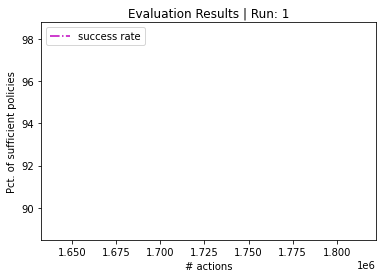

Policy performance decreased! Run-1 terminated!


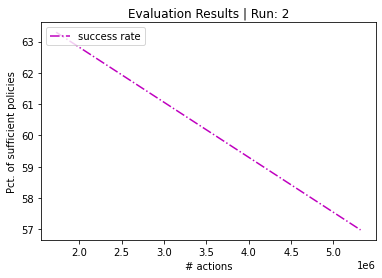

Policy performance decreased! Run-2 terminated!


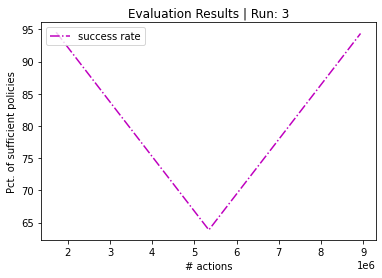

Policy performance decreased! Run-3 terminated!


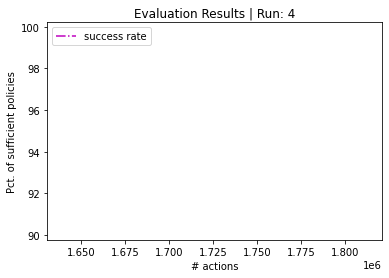

Policy performance decreased! Run-4 terminated!


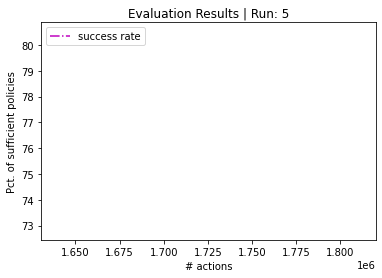

In [ ]:
configs = {'S': [200]
          , 'Actions' : [3]
          , 'Roll-outs': [200]
          , 'Significance' : [0.025, 0.05, 0.1]
          }

agg_results = []

eval_count = len(configs['S'])*len(configs['Actions'])*len(configs['Roll-outs'])*len(configs['Significance'])

pbar_evals = tqdm.notebook.tqdm(total=eval_count, desc="Evaluations", leave=False)

for sample_size in configs['S']:
        
    for rollout_max in configs['Roll-outs']:

        for sig_lvl in configs['Significance']:

            run_results = evaluations_per_config(s_size = sample_size
                                                , n_actions = configs['Actions'][0]
                                                , max_n_rollouts = rollout_max
                                                , sig_lvl = sig_lvl
                                                , runs_per_config = 10
                                                , off_policy_explr =  True
                                                , print_run_eval_plot = True)

            agg_results.append(run_results)

            pbar_evals.update(1)
                
pbar_evals.close()
                

---

In [24]:
results_dfs = []
for result in agg_results:
    results_dfs.append(pd.DataFrame(result))

results_df = pd.concat(results_dfs)

results_df.to_excel('original_experiment_results_para_config_7m.xlsx',index=False)